In [1]:
%matplotlib inline


# Animated histogram


Use a path patch to draw a bunch of rectangles for an animated histogram.



In [2]:
import numpy as np
import pyro
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

mu = 0
sigma = 0.5

def distribution(mean, variance, numbers):
    reasult = []
    for i in range(numbers):
        x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
        reasult.append(x)
    return reasult

# histogram our data with numpy
data = distribution(mu, sigma, 1000)
n, bins = np.histogram(data, 500, density=True)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

Here comes the tricky part -- we have to set up the vertex and path codes
arrays using ``plt.Path.MOVETO``, ``plt.Path.LINETO`` and
``plt.Path.CLOSEPOLY`` for each rect.

* We need 1 ``MOVETO`` per rectangle, which sets the initial point.
* We need 3 ``LINETO``'s, which tell Matplotlib to draw lines from
  vertex 1 to vertex 2, v2 to v3, and v3 to v4.
* We then need one ``CLOSEPOLY`` which tells Matplotlib to draw a line from
  the v4 to our initial vertex (the ``MOVETO`` vertex), in order to close the
  polygon.

<div class="alert alert-info"><h4>Note</h4><p>The vertex for ``CLOSEPOLY`` is ignored, but we still need a placeholder
  in the ``verts`` array to keep the codes aligned with the vertices.</p></div>



In [3]:
nverts = nrects * (1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom

To animate the histogram, we need an ``animate`` function, which generates
a random set of numbers and updates the locations of the vertices for the
histogram (in this case, only the heights of each rectangle). ``patch`` will
eventually be a ``Patch`` object.



In [4]:
patch = None

def init():
    data = np.random.randn(1000)
    n, bins = np.histogram(data, 100) 


def animate(i):
    # simulate new data coming in
    lista = [pyro.sample("normal_sampling", pyro.distributions.Normal(mu, sigma)) for _ in range(100)]
    data.extend(lista)
    n, bins = np.histogram(data, 500, density=True)
    top = bottom + n
    verts[1::5, 1] = top
    verts[2::5, 1] = top
    return [patch, ]

And now we build the `Path` and `Patch` instances for the histogram using
our vertices and codes. We add the patch to the `Axes` instance, and setup
the `FuncAnimation` with our animate function.



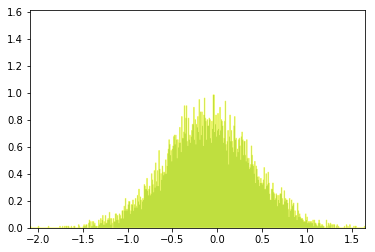

In [5]:
fig, ax = plt.subplots()
barpath = path.Path(verts, codes)
patch = patches.PathPatch(
    barpath, facecolor='green', edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())

anim = animation.FuncAnimation(fig, animate,
                                   frames=100, interval=20, blit=True)
HTML(anim.to_jshtml())